In [1]:
import os, sys

import numpy as np

import torch
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

import pandas as pd

sys.path.append('../..')

from lib.datasets import (get_train_test_img_ids_split, get_kfolds, actual_lbl_nums,
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          patches_csv_path, patches_path)
from lib.dataloaders import PatchesDataset, imread
from lib.augmentations import augment_empty, augment_v1
from lib.models.unetv1 import get_model

train_img_ids, test_img_ids = get_train_test_img_ids_split()

from tqdm.auto import tqdm
from multiprocessing import Pool

In [2]:
batch_size = 64
val_loader = torch.utils.data.DataLoader(
    PatchesDataset(test_img_ids, transform=augment_empty,
                   scale=0.5,
                   load_masks=True),
    batch_size=batch_size, shuffle=True,
    num_workers=12, pin_memory=False,
)

In [3]:
for imgs, masks, labels, providers, isup_grades, g_scores in val_loader:
    break

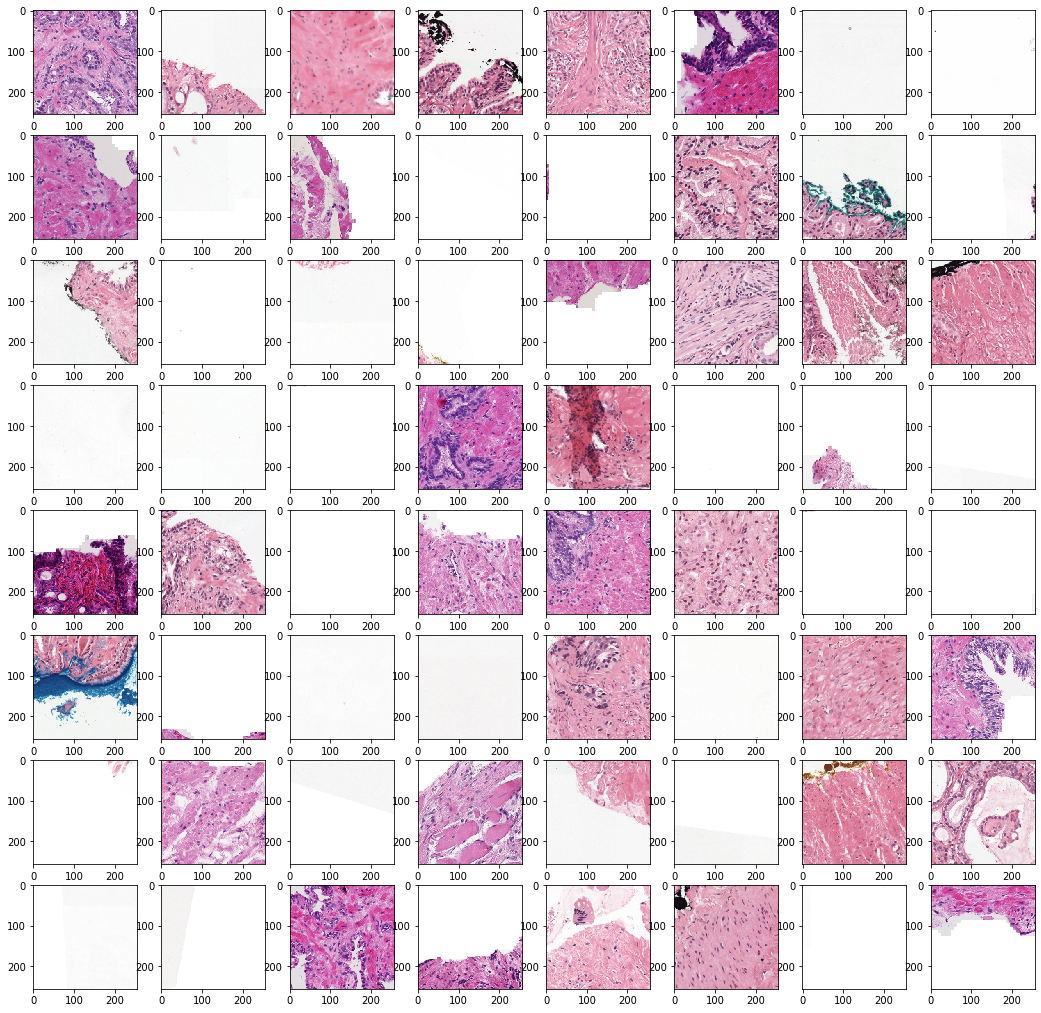

In [4]:
fig, axs = plt.subplots(8, 8, figsize=(18, 18))
axs = axs.ravel()
for n in range(64):
    axs[n].imshow(imgs[n].cpu().transpose(0, -1));

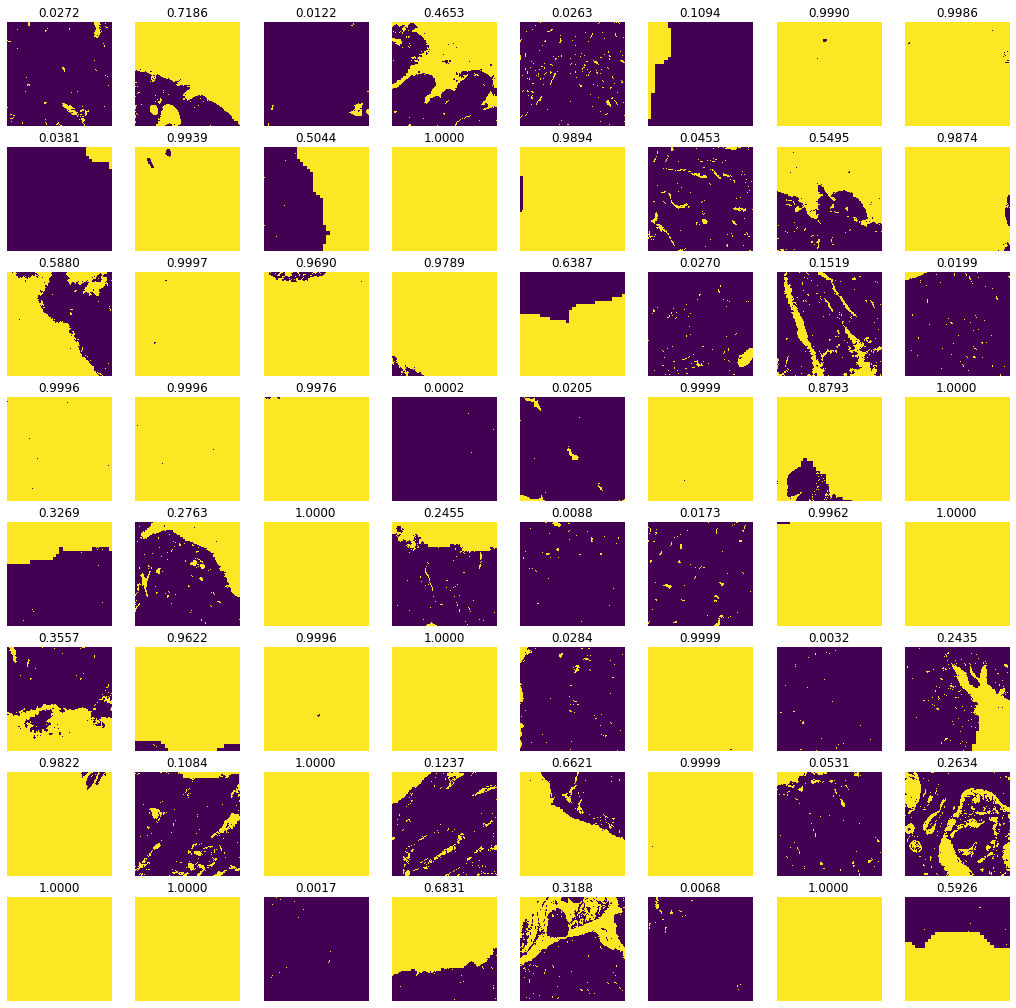

In [12]:
fig, axs = plt.subplots(8, 8, figsize=(18, 18))
axs = axs.ravel()
for n in range(64):
    img = (imgs[n].cpu().transpose(0, -1).numpy() * 255).astype(np.uint8)
    axs[n].imshow(img);
    #d_img = np.abs(img.astype(np.float32) - 255).mean(-1)
    #b_img = d_img < 32
    #enough_bg = b_img.mean() < 0.90
    
    b_img = np.all(img > 230, axis=-1)
    
    axs[n].imshow(b_img, vmin=0, vmax=1);
    axs[n].set_title(f"{b_img.mean():.4f}");
    axs[n].axis('off');

In [13]:
121

121

In [14]:
df = pd.read_csv(patches_csv_path)

In [15]:
import cv2

In [16]:
def process_row(row):
    image_id, y, x = row.image_id, row.y, row.x
    fname = f"{image_id}_{y}_{x}.jpeg"
    # img = imread(os.path.join(patches_path, "imgs", fname))
    # img = img / 255
    img = cv2.imread(os.path.join(patches_path, "imgs", fname))

    b_img = np.all(img > 230, axis=-1)
    enough_bg = b_img.mean() < 0.90
    
    return row, enough_bg

new_rows = []
with Pool(processes=11) as pool:
    for row, enough_bg in tqdm(pool.imap_unordered(process_row, (r[1] for r in df.iterrows())), total=len(df)):
        if enough_bg:
            new_rows.append(row)

In [17]:
new_df = pd.DataFrame(new_rows)

In [18]:
new_df.to_csv("/mnt/SSDData/pdata/processed/patches_clean90_512.csv", index=False)

In [19]:
len(new_df)

1648199

In [20]:
len(df)

2576729